In [1]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
cfg.data.sdoml.sub_directory.eve

'EVE_legacy.zarr"'

In [4]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
    

In [273]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 2,
    num_workers = 10,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2010-01-01',
    end_date   = '2010-12-31',
    dim = False,
    sampling_period = '10days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()



[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [274]:
dltrain = data_module.train_dataloader()
train_iter = iter(dltrain)

In [275]:
b = next(train_iter)
b['timestamps']

[('2010-06-30 14:24:00', '2010-06-28 14:12:00'),
 ('2010-07-09 23:24:00', '2010-06-29 14:24:00')]

In [279]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class Encoder(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        
        self.encoding_size = encoding_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 3, 1, stride=1)
        self.conv2 = nn.Conv2d(3, 3, 64, stride=1)
        self.conv3 = nn.Conv2d(3, 3, 64, stride=1)
        self.conv4 = nn.Conv2d(3, 3, 64, stride=2)
        #self.conv5 = nn.Conv2d(3, 3, 64, stride=1)
        #self.conv6 = nn.Conv2d(3, 3, 32, stride=1)
        #self.conv7 = nn.Conv2d(3, 64, 1, stride=1)
        self.fc1 = nn.Linear(13467, encoding_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        #x = F.relu(self.conv7(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x) # last encoding layer
    
        return x

    
class Encoder(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        
        self.encoding_size = encoding_size
        self.pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 10, 4, stride=4)
        self.conv2 = nn.Conv2d(10, 10, 4, stride=4)
        self.conv3 = nn.Conv2d(10, 10, 4, stride=2)
        #self.conv4 = nn.Conv2d(10, 10, 2, stride=2)
        self.fc1 = nn.Linear(490, encoding_size)

    def forward(self, x):
        x = self.pool(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.elu(self.fc1(x)) # last encoding layer
    
        return x
    
class EncoderMLP(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        
        self.encoding_size = encoding_size
        self.pool = nn.AvgPool2d(4 ,4)
        self.fc1 = nn.Linear(128*128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, encoding_size)

    def forward(self, x):
        x = self.pool(x)       # downsample img
        x = torch.flatten(x,1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
    
        return x
    
    
class TimedeltaMLP(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.fc1 = nn.Linear(encoding_size*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512,1)
        

    def forward(self, x):        
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x    
    
class AssembledModel(nn.Module):
    
    def __init__(self, encoding_size, encoder_class):
        super().__init__()
        self.encoder0         = encoder_class(encoding_size)
        self.encoder1         = encoder_class(encoding_size)
        self.timedelta_model = TimedeltaMLP(encoding_size)
        
    def forward(self, x1, x2):

        x1 = self.encoder0(x1)
        x2 = self.encoder1(x2)
        
        x = torch.concat([x1, x2], dim=1)
        x = self.timedelta_model(x)
        
        return x

## check embeddings shape

In [280]:
model = AssembledModel(encoding_size=256, encoder_class=Encoder)

In [281]:
im1 = torch.rand((4,1,512,512))
im2 = torch.rand((4,1,512,512))

o1 = model.encoder0(im1)
o2 = model.encoder1(im2)
o1.shape, o2.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [282]:
o = model(im1, im2)
o.shape

torch.Size([4, 1])

## instantiate model (encoder + time delta predictor) 

In [283]:
model = AssembledModel(encoding_size=256, encoder_class=Encoder)
channel_idx = 0

psize = [np.prod(i.shape) for i in model.encoder0.parameters()]
print ("encoder parameters        ", sum(psize))

psize = [np.prod(i.shape) for i in model.timedelta_model.parameters()]
print ("timedelta model parameters", sum(psize))

psize = [np.prod(i.shape) for i in model.parameters()]
print ("model total parameters    ", sum(psize))

encoder parameters         129086
timedelta model parameters 1313281
model total parameters     1571453


## build dadtaloader objects

In [284]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(7278, 1033)

## send models to cuda and init optimizer

In [285]:
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

## training loop

In [ ]:
et = ElapsedTimes()
num_epochs = 100
lossh, lossvalh = [], []
predictions, targets = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    for step, batch in enumerate(dltrain):
        # extract data from batch
        with et("batch"):
            n = len(batch['image_stack'])
            
            # assumes two timeframes, compute actual time between both timeframes and scales it
            # wrt to the sampling period so that it is in [0,1]
            t = batch['timestamps']
            tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                          for ni in range(n)])\
                                       .reshape(-1,1)\
                                       .cuda()

            image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:].cuda()
            image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:].cuda()

        # run model
        with et("forward"):
            
            tdeltas_pred = model(image_stack_t0, image_stack_t1)

        # compute loss
        with et("loss"):
            loss = loss_fn(tdeltas_pred,tdeltas_truth)

        # backpropage and sigmoidupdate
        with et("backward"):
            loss.backward()
            optimizer.step()
            
            
        for p in tdeltas_pred:
            predictions.append(p)
            
        for t in tdeltas_truth:
            targets.append(t)
            
            
        with et("validation"):
            """
            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()
            """
            lossvaln = 0.
        with et("logging"):
            # cosmetics
            lossn = loss.detach().cpu().numpy()
            lossh.append(lossn)

            lossvalh.append(lossvaln)


            psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
            lossm = np.mean(lossh[-100:])
            lossvalm = np.mean(lossvalh[-100:])
            epoch_time = (datetime.now() - t0).seconds
            print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

    print()

epoch   0 step 7277 loss 0.30701 lossval 0.00000 params 0.0646996 epoch_time 260 secs
epoch   1 step 7277 loss 0.28208 lossval 0.00000 params 0.1181392 epoch_time 259 secs
epoch   2 step 7277 loss 0.34110 lossval 0.00000 params 0.1712968 epoch_time 405 secs
epoch   3 step 7277 loss 0.30770 lossval 0.00000 params 0.2252201 epoch_time 257 secs
epoch   4 step 7277 loss 0.27501 lossval 0.00000 params 0.2839285 epoch_time 264 secs
epoch   5 step 7277 loss 0.37613 lossval 0.00000 params 0.3463461 epoch_time 280 secs
epoch   6 step 7277 loss 0.39619 lossval 0.00000 params 0.4115957 epoch_time 275 secs
epoch   7 step 7277 loss 0.34661 lossval 0.00000 params 0.4770279 epoch_time 272 secs
epoch   8 step 7277 loss 0.33899 lossval 0.00000 params 0.5432373 epoch_time 271 secs
epoch   9 step 7277 loss 0.28078 lossval 0.00000 params 0.6103956 epoch_time 266 secs
epoch  10 step 7277 loss 0.34627 lossval 0.00000 params 0.6744642 epoch_time 265 secs
epoch  11 step 7277 loss 0.36256 lossval 0.00000 param

In [1]:
tdeltas_pred.shape

NameError: name 'tdeltas_pred' is not defined

In [224]:
image_stack_t0.shape

torch.Size([2, 1, 512, 512])

5.864974737167358

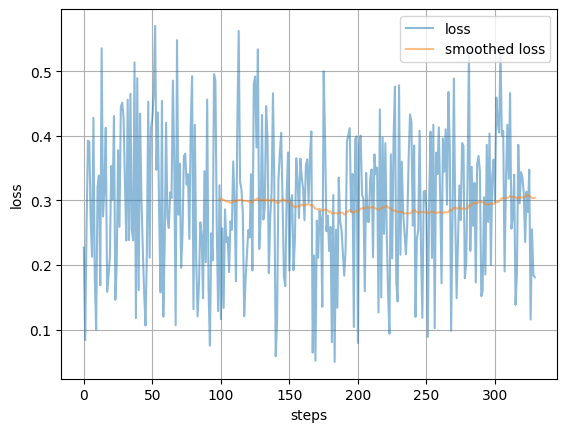

In [272]:
ploth(lossh)
sum(list(et.elapsed_times.values()))

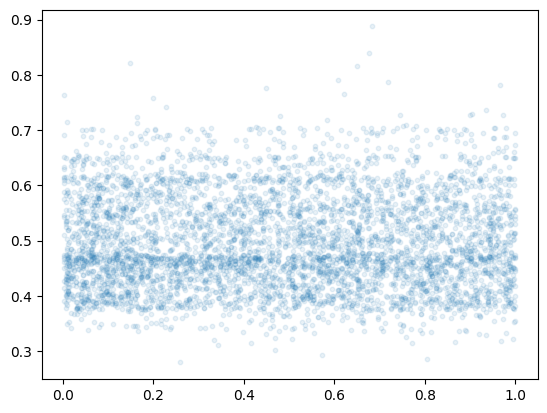

In [270]:
plt.scatter(torch.tensor(targets).cpu().numpy(), torch.tensor(predictions).cpu().numpy(), alpha=0.1, s=10)

In [218]:
params = [p.cpu().detach().numpy() for p in model.encoder.parameters()]
[p.shape for p in params]

[(10, 1, 16, 16),
 (10,),
 (10, 10, 8, 8),
 (10,),
 (10, 10, 4, 4),
 (10,),
 (10, 10, 2, 2),
 (10,),
 (256, 1690),
 (256,)]

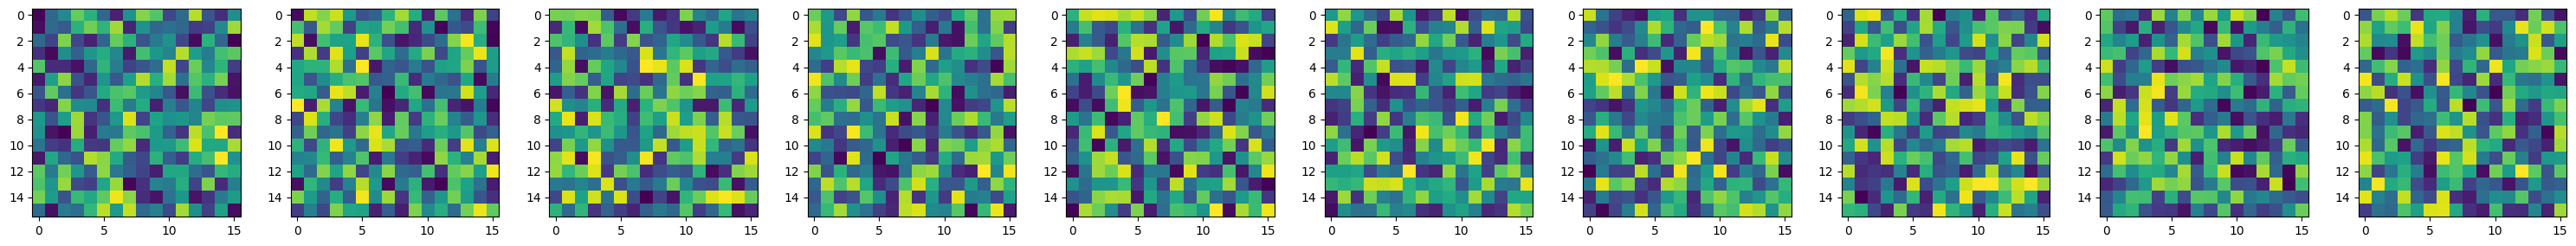

In [219]:
for ax,i in subplots(len(params[0])):
    plt.imshow(params[0][i,0])

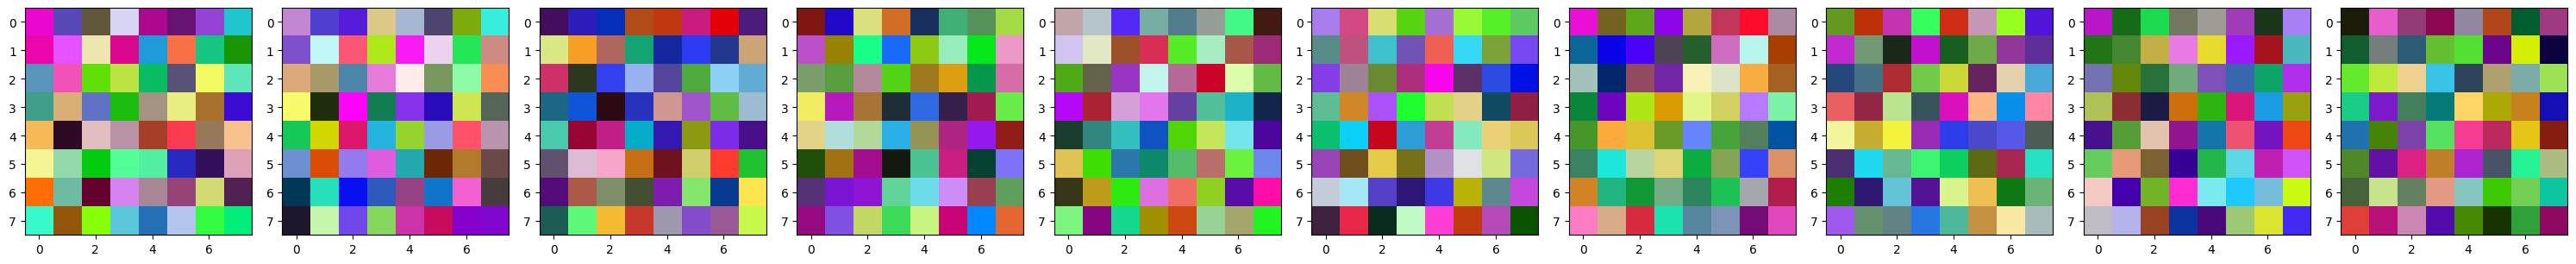

In [220]:
for ax,i in subplots(len(params[0])):
    z = np.transpose(params[2][i,:3], (1,2,0))
    a,b = np.percentile(z, (0,100))
    z = (z-a)/(b-a)
    plt.imshow(z)

In [73]:
ntargets = torch.tensor(targets).cpu().numpy()+1e-5
npredictions = torch.tensor(predictions).cpu().numpy() + 1e-5

def timedelta2str(k):
    hrs, rem = divmod(k.seconds, 3600)
    mins, secs = divmod(rem, 60)
    s = f"{k.days} days {hrs}h {mins}m"
    return s

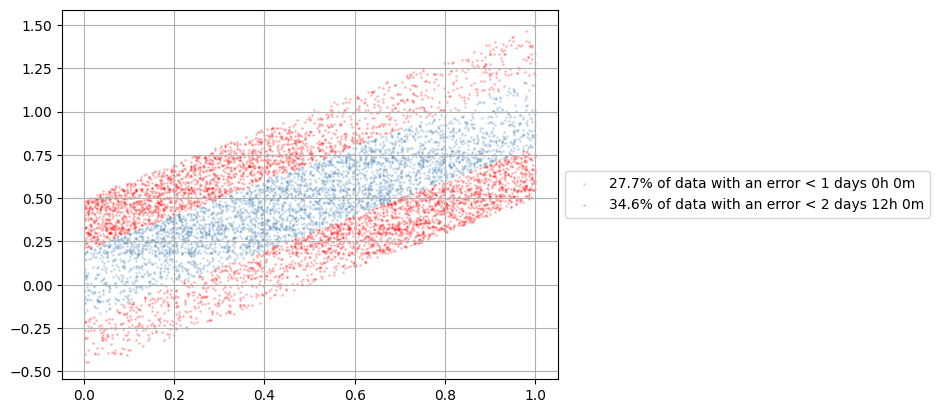

In [31]:
ndiff = np.abs(ntargets - npredictions)
idxs = (ndiff<.2)

s = timedelta2str(pd.Timedelta(data_module.sampling_period)*.2)

plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='steelblue', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")

s = timedelta2str(pd.Timedelta(data_module.sampling_period)*.5)
idxs = (ndiff>.2)&(ndiff<.5)
plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='red', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")


plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [105]:
tdeltas_truth

tensor([[0.3950],
        [0.1433],
        [0.9733],
        [0.2900],
        [0.5450],
        [0.1150],
        [0.9900],
        [0.6567]], device='cuda:0')

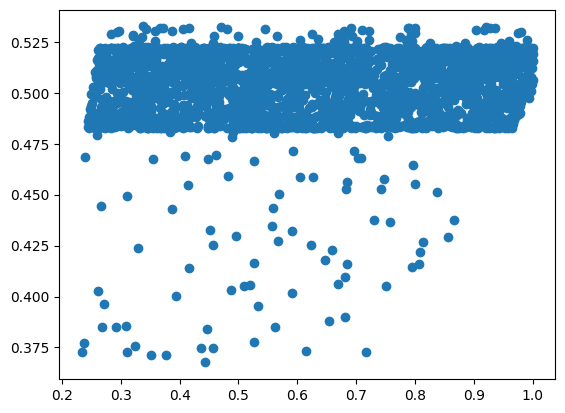

In [106]:
nratio = ntargets / npredictions
a,b = np.percentile(nratio, [1,99])
idxs = ((nratio>.5) & (nratio<2))
plt.scatter(ntargets[idxs], npredictions[idxs])

In [107]:
def timedelta2str(k):
    hrs, rem = divmod(k.seconds, 3600)
    mins, secs = divmod(rem, 60)
    s = f"{k.days} days {hrs}h {mins}m"
    return s

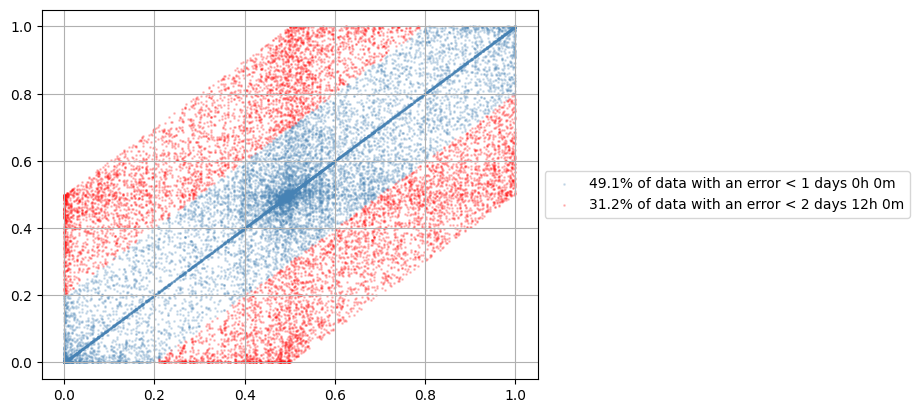

In [48]:
ndiff = np.abs(ntargets - npredictions)
idxs = (ndiff<.2)

s = timedelta2str(pd.Timedelta(data_module.sampling_period)*.2)

plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='steelblue', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")

s = timedelta2str(pd.Timedelta(data_module.sampling_period)*.5)
idxs = (ndiff>.2)&(ndiff<.5)
plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='red', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")


plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


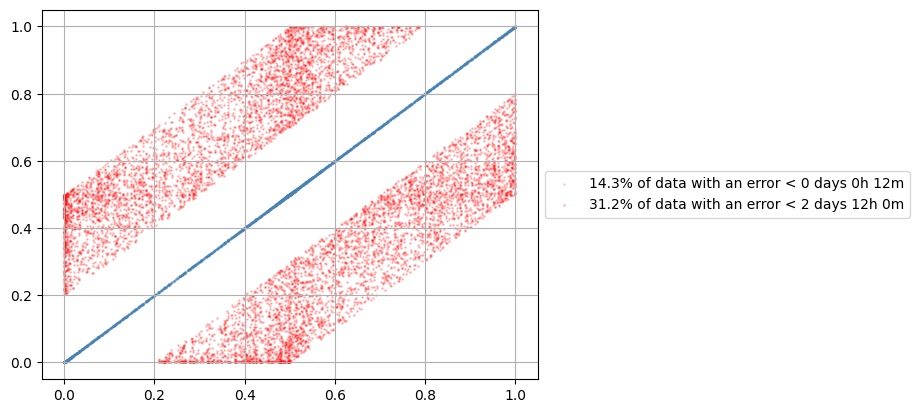

In [51]:
ndiff = np.abs(ntargets - npredictions)
idxs = (ndiff<1/(5*24*5))

s = timedelta2str(pd.Timedelta('12min'))

plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='steelblue', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")

s = timedelta2str(pd.Timedelta(data_module.sampling_period)*.5)
idxs = (ndiff>.2)&(ndiff<.5)
plt.scatter(ntargets[idxs], npredictions[idxs], s=1, alpha=.2, c='red', label=f"{np.mean(idxs)*100:.1f}% of data with an error < {s}")


plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [45]:
timedelta2str(pd.Timedelta(data_module.sampling_period)*.2)

'1 days 0h 0m'

In [ ]:
ploth(lossh)
sum(list(et.elapsed_times.values()))

In [13]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

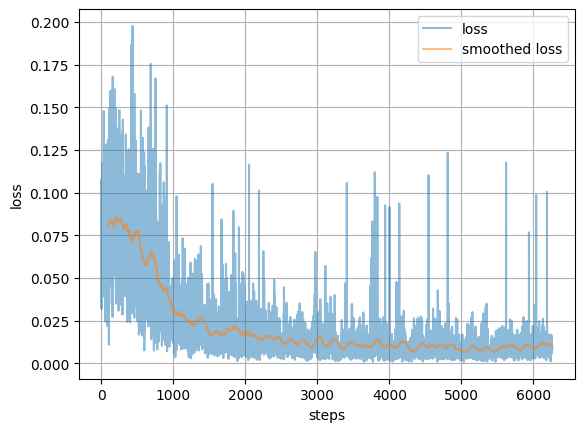

In [14]:
ploth(lossh)


# get predictions on datasetm

In [34]:
modelcpu = model.cpu()
def get_predictions(dataloader):

    targets, predictions = [], []
    
    for batch in pbar(dataloader, max_value=len(dataloader)):
        # extract data from batch
        n = len(batch['image_stack'])

        # assumes two timeframes, compute actual time between both timeframes and scales it
        # wrt to the sampling period so that it is in [0,1]
        t = batch['timestamps']
        tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                      for ni in range(n)])\
                                   .reshape(-1,1)
                                   

        image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:]
        image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:]

        # run model
        tdeltas_pred = modelcpu(image_stack_t0, image_stack_t1)

        for p in tdeltas_pred:
            predictions.append(p)
            
        for t in tdeltas_truth:
            targets.append(p)
        
    return targets, predictions

In [ ]:
dltrain = data_module.train_dataloader()
trtargets, trpreds = get_predictions(dltrain)

  1% (20 of 1858) |                      | Elapsed Time: 0:00:18 ETA:   0:28:38

In [ ]:
torch.save(model, f"{model_name}.ckpt")


In [23]:
    dataloader = data_module.train_dataloader()
    
    targets, predictions = [], []
    
    for batch in pbar(dataloader, max_value=len(dataloader)):
        # extract data from batch
        n = len(batch['image_stack'])

        # assumes two timeframes, compute actual time between both timeframes and scales it
        # wrt to the sampling period so that it is in [0,1]
        t = batch['timestamps']
        tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                      for ni in range(n)])\
                                   .reshape(-1,1)\
                                   .cuda()

        image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:].cuda()
        image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:].cuda()

        # run model
        tdeltas_pred = model(image_stack_t0, image_stack_t1)

        for p in tdeltas_pred:
            predictions.append(p)
            
        for t in tdeltas_truth:
            targets.append(p)

  0% (0 of 1858) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

TypeError: string indices must be integers

In [26]:
dataloader

In [25]:
batch

'image_stack'

In [ ]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
dltest  = data_module.test_dataloader()

In [227]:
dltrain = data_module.train_dataloader()

for batch in dltrain:
    print (".", end="")
    if np.random.random()<.01:
        break


................................................................

In [228]:
t = batch['timestamps']
tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                              for ni in range(n)])\
                           .reshape(-1,1)\
                           .cuda()

image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:].cuda()
image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:].cuda()


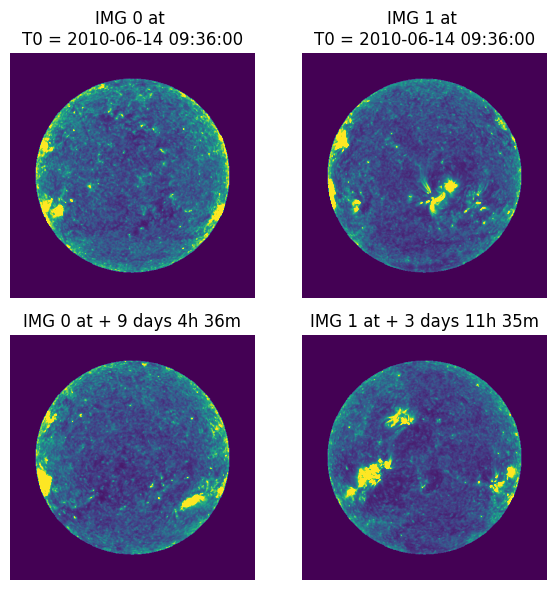

In [230]:
batch_element = 0
n = len(batch['image_stack'])

for ax,i in subplots(n*2, n_cols=n, usizex=3, usizey=3):

    if i<n:
        xi = image_stack_t0[i][0].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)
        plt.title(f"IMG {i} at \nT0 = {batch['timestamps'][0][0]}")

    else:
        xi = image_stack_t1[i-n][0].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)
        
        k = tdeltas_truth[i-n,0].cpu().numpy() * pd.Timedelta(data_module.sampling_period)
        hrs, rem = divmod(k.seconds, 3600)
        mins, secs = divmod(rem, 60)
        s = f"{k.days} days {hrs}h {mins}m"
        plt.title(f"IMG {i-n} at + {s}")
    plt.axis("off")


In [231]:
batch['timestamps']

[('2010-06-14 09:36:00', '2010-08-04 15:36:00'),
 ('2010-06-23 14:12:00', '2010-08-08 03:12:00')]

In [232]:
batch['timestamps'][0]

('2010-06-14 09:36:00', '2010-08-04 15:36:00')

In [39]:
k = tdeltas_truth[batch_element,0].cpu().numpy() * pd.Timedelta(data_module.sampling_period)
hrs, rem = divmod(k.seconds, 3600)
mins, secs = divmod(rem, 60)
f"{k.days} days {hrs}h {mins}m"

Timedelta('2 days 10:48:00.004119873')

In [41]:
hrs, rem = divmod(k.seconds, 3600)
mins, secs = divmod(rem, 60)
f"{k.days} days {hrs}h {mins}m"

In [44]:
f"{k.days} days {hrs}h {mins}m"

'2 days 10h 48m'

In [ ]:
k.

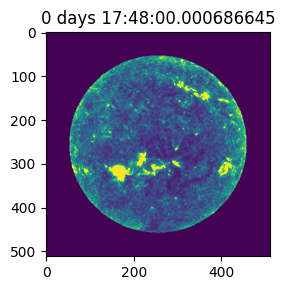

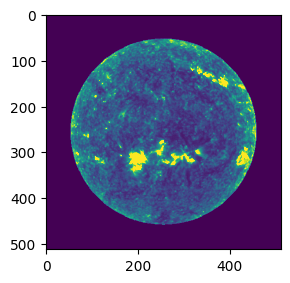

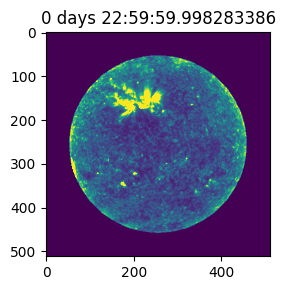

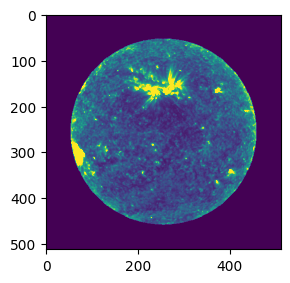

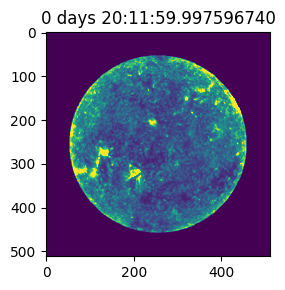

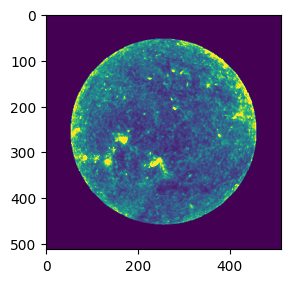

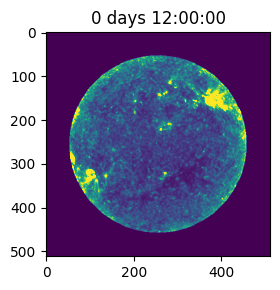

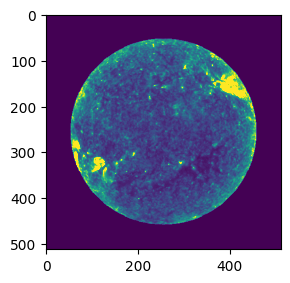

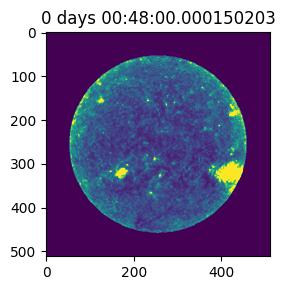

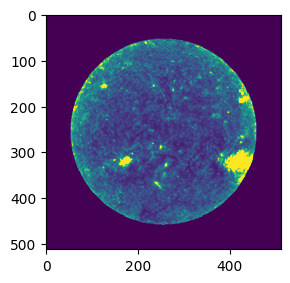

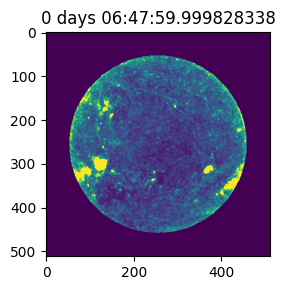

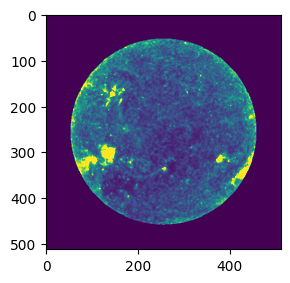

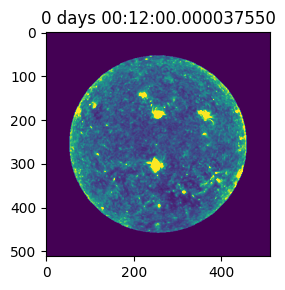

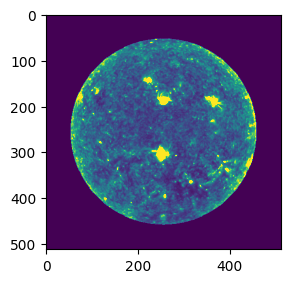

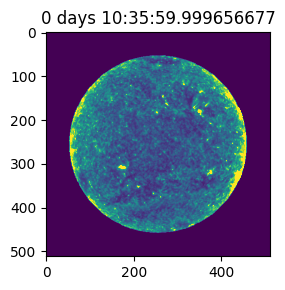

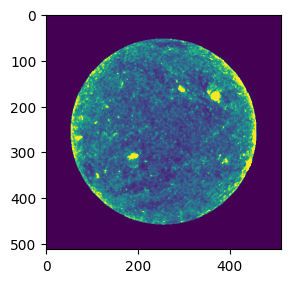

In [71]:

batch_element = 0
for batch_element in range(len(batch['image_stack'])):
    x0 = image_stack_t0[batch_element]
    x1 = image_stack_t1[batch_element]

    for ax,i in subplots(len(x0)):
        if i==0:
            s = str(tdeltas_truth[batch_element,0].cpu().numpy() * pd.Timedelta(data_module.sampling_period))
            plt.title(s)

        xi = x0[i].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)

    for ax,i in subplots(len(x1)):
        xi = x1[i].cpu().numpy()
        a,b = np.percentile(xi, [0,99])
        plt.imshow(xi, vmin=a, vmax=b)

